# Predict slab dip

Predict the average slab dip, $\theta_{\mathrm{av}}$, of subducting oceanic lithosphere using the following relation,

$$
\theta_{\mathrm{av}} = A (v_c + v_t) h_{\mathrm{plate}} + B
$$

where $h_{\mathrm{plate}}$ is the thickness of the subducting plate calculated by plate models of lithospheric cooling (from [Grose, 2012](https://doi.org/10.1016/j.epsl.2012.03.037)), $v_c$ is the convergence velocity, $v_t$ is the rate of trench migration, and $A$ and $B$ are coefficients obtained from a weighted linear regression.
Using the present-day configuration of subduction boundaries and slab dips obtained from the Slab2 model ([Hayes _et al._, 2018](https://doi.org/10.1126/science.aat4723)), we obtain $A = 0.006$ and $B = 8$ with standard deviations of $\sigma_A = 0.001$ and $\sigma_B = 5$.


## Dependencies

To run this notebook some dependencies are required:

- [pygplates](https://www.gplates.org/download/)
- [PlateTectonicTools](https://github.com/EarthByte/PlateTectonicTools/tree/master/ptt)
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/installing.html) (for mapping)
- [netCDF4](https://pypi.org/project/netCDF4/) (to extract age grids of the seafloor)


## Data packages

A plate reconstruction and corresponding age grids of the seafloor are required to predict slab dip. These may be downloaded from https://www.earthbyte.org/gplates-2-3-software-and-data-sets/

The slab dip calculation has been tested on [Clennett _et al._ (2020)](https://doi.org/10.1029/2020GC009117) and [Müller _et al._ (2019)](https://doi.org/10.1029/2018TC005462) plate reconstructions but should also work fine for other plate reconstructions.


#### References

- Grose, C. J. (2012). Properties of oceanic lithosphere: Revised plate cooling model predictions. Earth and Planetary Science Letters, 333–334, 250–264. https://doi.org/10.1016/j.epsl.2012.03.037
- Hayes, G. P., Moore, G. L., Portner, D. E., Hearne, M., Flamme, H., Furtney, M., & Smoczyk, G. M. (2018). Slab2, a comprehensive subduction zone geometry model. Science, 362(6410), 58–61. https://doi.org/10.1126/science.aat4723
- Clennett, E. J., Sigloch, K., Mihalynuk, M. G., Seton, M., Henderson, M. A., Hosseini, K., et al. (2020). A Quantitative Tomotectonic Plate Reconstruction of Western North America and the Eastern Pacific Basin. Geochemistry, Geophysics, Geosystems, 21(8), 1–25. https://doi.org/10.1029/2020GC009117
- Müller, R. D., Zahirovic, S., Williams, S. E., Cannon, J., Seton, M., Bower, D. J., et al. (2019). A Global Plate Model Including Lithospheric Deformation Along Major Rifts and Orogens Since the Triassic. Tectonics, 38(6), 1884–1907. https://doi.org/10.1029/2018TC005462

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pygplates
import numpy as np
import csv
import sys
import gplately
import cartopy.crs as ccrs

import ptt
import ptt.subduction_convergence

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from scipy.stats import gaussian_kde
from scipy.spatial import cKDTree
from scipy import ndimage
import netCDF4
import stripy

import warnings
import os, glob

Let's compare subduction zone data between two plate models: Müller et al. 2016 and Müller et al. 2019.

In [2]:
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features)

gdownload2 = gplately.download.DataServer("Muller2016")
rotation_model2, topology_features2, static_polygons2 = gdownload2.get_plate_reconstruction_files()
model2 = gplately.PlateReconstruction(rotation_model2, topology_features2)

# Tessellate the subduction zones to 0.5 degrees.
tessellation_threshold_radians = np.radians(0.05)

extent_globe = [-180,180,-90,90]

## Get kinematic data

Using `PlateTectonicTools` we extract plate kinematic data for the present-day configuration of subduction zones to calculate the dip angle of subducting slabs.

In [4]:

time = np.arange(0,10)
def get_trench_volume_rate(gdownload_object, model, time):
    
    mean_plate_thickness = []
    mean_subduction_segment_length = []
    mean_subduction_convergence_rate = []
    mean_subduction_volume_rate = []
    total_subduction_volume_rate  = []
        
    def My2s(Ma):
        return Ma*3.1536e13

    for reconstruction_time in time:
        # calculate subduction convergence
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            subduction_data = ptt.subduction_convergence.subduction_convergence(
                model.rotation_model,
                model.topology_features,
                tessellation_threshold_radians,
                reconstruction_time,
                velocity_delta_time=1,
                anchor_plate_id=0,
                output_subducting_absolute_velocity_components=True)
            subduction_data = np.vstack(subduction_data)

        subduction_lon     = subduction_data[:,0]
        subduction_lat     = subduction_data[:,1]
        subduction_angle   = subduction_data[:,3]
        subduction_norm    = subduction_data[:,7]
        subduction_pid_sub = subduction_data[:,8]
        subduction_pid_over= subduction_data[:,9]
        subduction_length  = np.radians(subduction_data[:,6]) * pygplates.Earth.mean_radius_in_kms * 1e3 # in metres
        subduction_convergence = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
        subduction_migration   = np.fabs(subduction_data[:,4])*1e-2 * np.cos(np.radians(subduction_data[:,5]))
        subduction_plate_vel = subduction_data[:,10]

        # remove entries that have "negative" subduction
        # this occurs when the subduction obliquity is greater than 90 degrees
        subduction_convergence = np.clip(subduction_convergence, 0, 1e99)

        # sample AgeGrid for current timestep
        agegrid = gdownload_object.get_age_grid(reconstruction_time)
        graster = gplately.Raster(model, array=agegrid)
        age_grid_filled = graster.fill_NaNs()
        age_interp = gplately.grids.sample_grid(subduction_lon, subduction_lat, age_grid_filled, extent_globe)
        subduction_age = age_interp
        thickness = gplately.tools.plate_isotherm_depth(My2s(age_interp))

        # calculate subduction volume rate - m * m * m/yr
        subduction_vol_rate = thickness*subduction_length*subduction_convergence # integrated along subduction len
        subduction_vol_rate *= 1e-9 # convert m^3/yr to km^3/yr

        # get the ratio of convergence velocity to trench migration
        vratio = (subduction_convergence + subduction_migration)/(subduction_convergence + 1e-22)
        vratio[subduction_plate_vel < 0] *= -1
        vratio = np.clip(vratio, 0.0, 1.0)

        # calculate slab dip using coefficients a and b
        coeff_a, coeff_b = 0.00639289, 8.00315437
        subduction_dip = coeff_a*(subduction_convergence*vratio)*thickness + coeff_b

        # calculate distance of arc to trench
        d_trench = 125.0/np.tan(np.radians(subduction_dip))

        mean_plate_thickness.append(thickness.mean())
        mean_subduction_segment_length.append(subduction_length.mean())
        mean_subduction_convergence_rate.append(subduction_convergence.mean())
        mean_subduction_volume_rate.append(subduction_vol_rate.mean())
        total_subduction_volume_rate.append(subduction_vol_rate.sum())
        
        #print("mean plate thickness = {:.2f} m".format(thickness.mean()))
        #print("mean subduction segment length = {:.2f} m".format(subduction_length.mean()))
        #print("mean subduction convergence rate = {:.4f} m/yr".format(subduction_convergence.mean()))
        #print("mean subduction volume rate = {:.4f} km^3/yr".format(subduction_vol_rate.mean()))
        #print("total subduction volume rate = {:.4f} km^3/yr \n".format(subduction_vol_rate.sum()))
        #print("{} : {}".format(reconstruction_time, subduction_vol_rate.sum()))
        
    return total_subduction_volume_rate

In [5]:
# Calculate the total subduction volume rate (km^3/yr) per timestep for each plate model
time = np.arange(0,231)
muller2019_volumes = get_trench_volume_rate(gdownload, model, time)
muller2016_volumes = get_trench_volume_rate(gdownload2, model2, time)

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/gplately/tools.py:105: UserWarning: Iterations did not converge below rtol=0.001
  warnings.warn("Iterations did not converge below rtol={}".format(rtol))
/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site

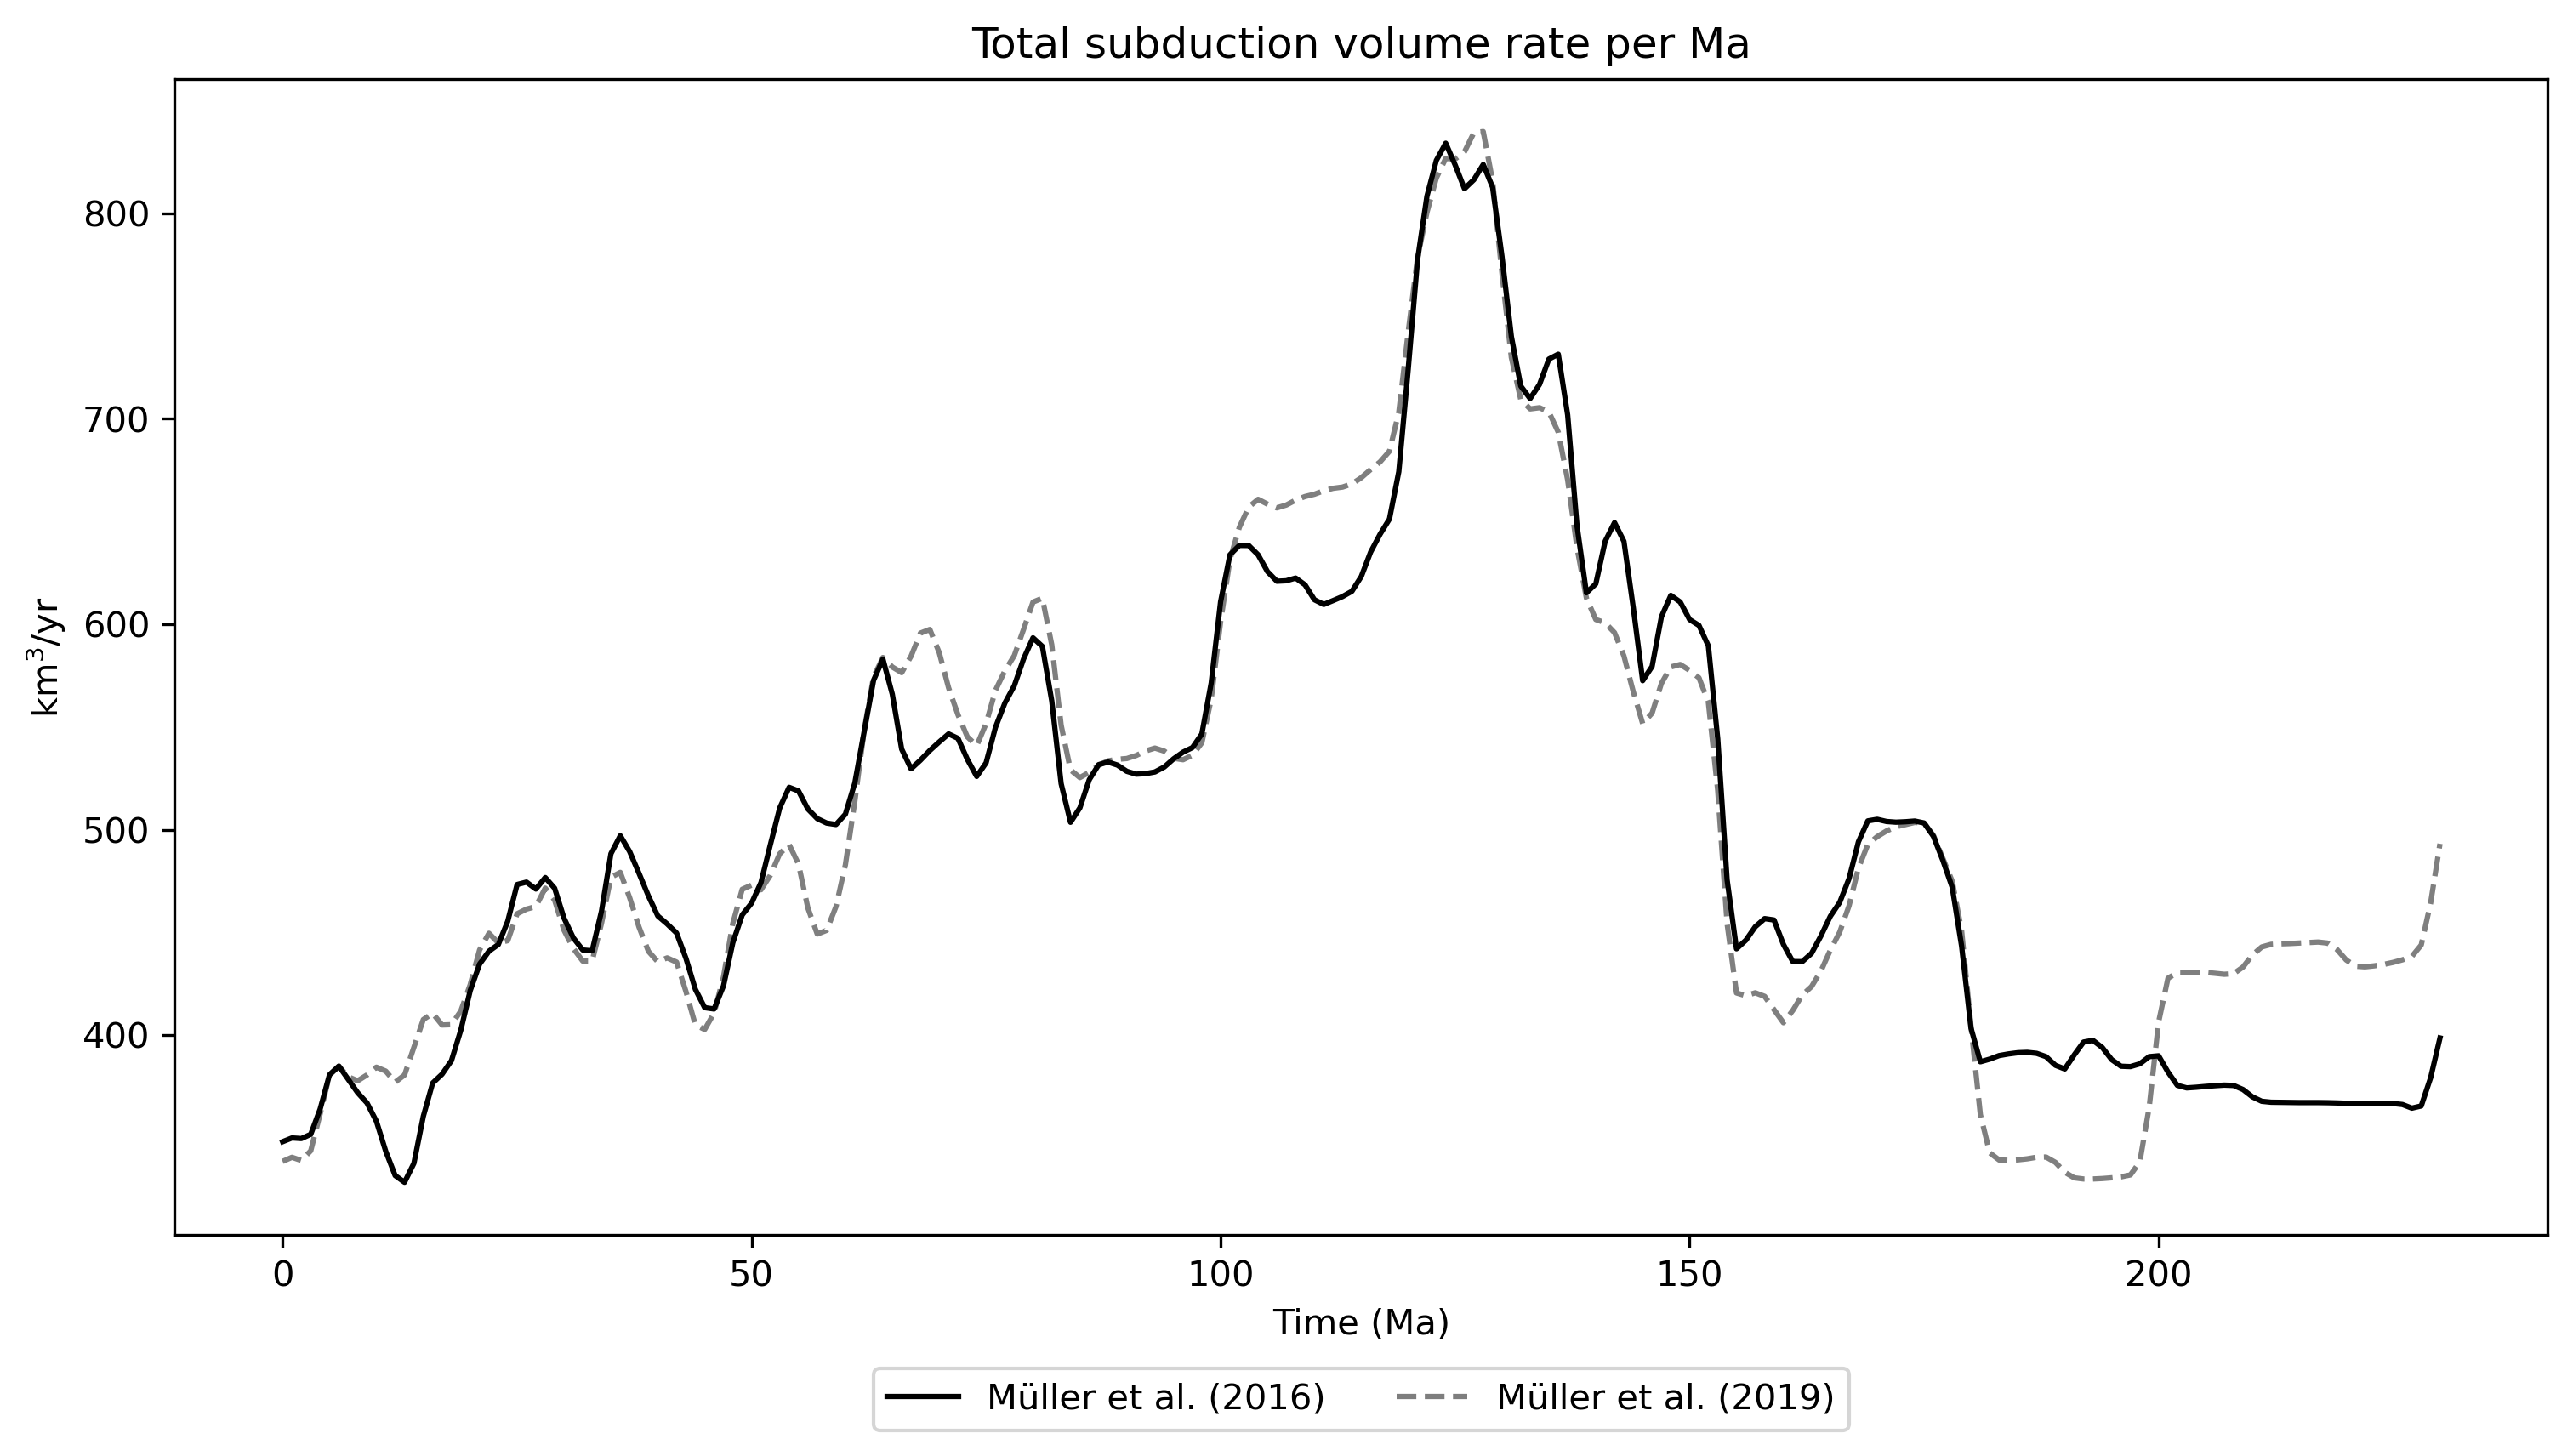

In [30]:
# Plot this data using a Gaussian filter
fig = plt.figure(figsize=(12,6), dpi=300)

from scipy.ndimage import gaussian_filter
muller2016_volumes_smoothed = gaussian_filter(muller2016_volumes, sigma=1)
muller2019_volumes_smoothed = gaussian_filter(muller2019_volumes, sigma=1)
plt.plot(time, muller2016_volumes_smoothed, color="k", label="Müller et al. (2016)")
plt.plot(time, muller2019_volumes_smoothed, linestyle="--", alpha=0.5, color="k", label="Müller et al. (2019)")
   
# Plot settings
plt.title("Total subduction volume rate per Ma")
plt.xlabel('Time (Ma)')
plt.ylabel('km$^3$/yr')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)